/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:27:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Acurácia: 0.8268156424581006
F1-score: 0.7703703703703704
ROC-AUC: 0.8378129117259552
Matriz de Confusão:
 [[96 14]
 [17 52]]


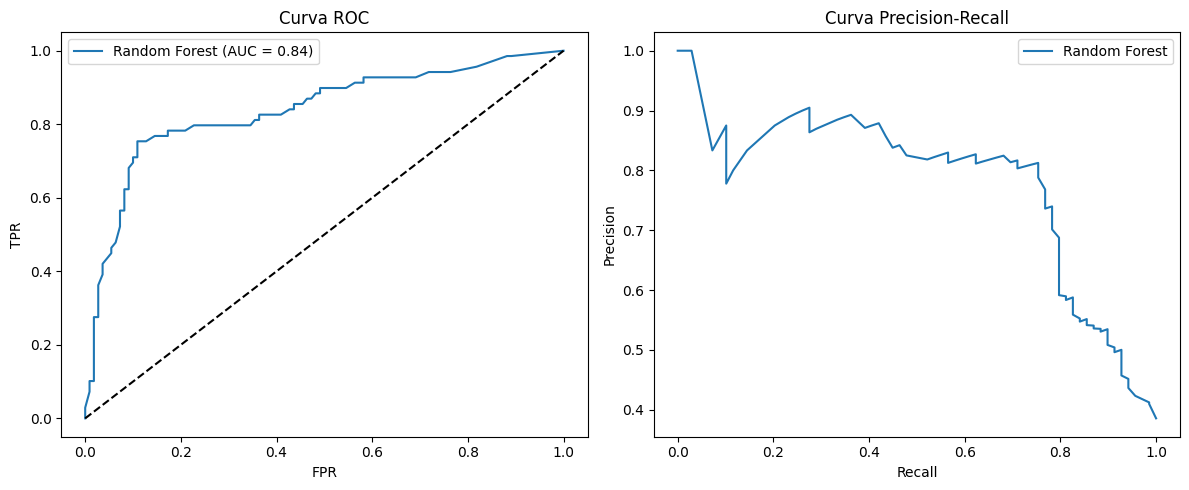

Acurácia: 0.8100558659217877
F1-score: 0.7068965517241379
ROC-AUC: 0.8237154150197628
Matriz de Confusão:
 [[104   6]
 [ 28  41]]


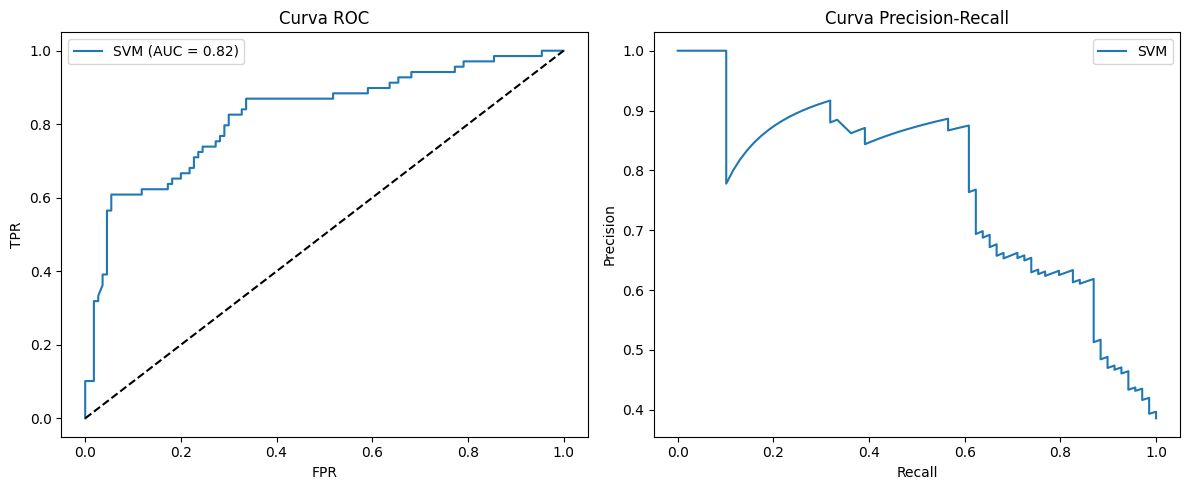

Acurácia: 0.7988826815642458
F1-score: 0.7391304347826086
ROC-AUC: 0.8005270092226614
Matriz de Confusão:
 [[92 18]
 [18 51]]


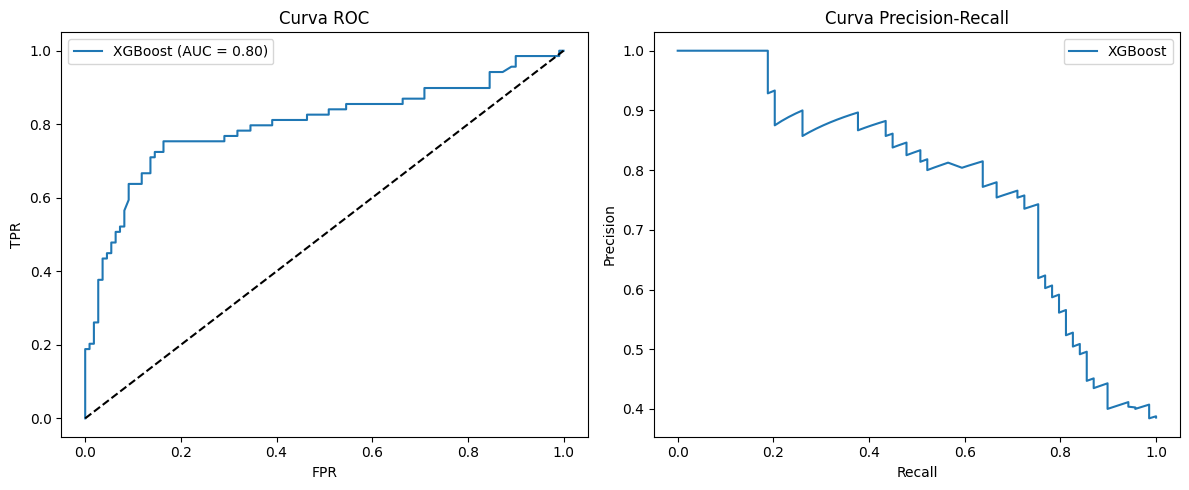

Melhores hiperparâmetros RF: {'modelo__n_estimators': 300, 'modelo__min_samples_split': 10, 'modelo__max_depth': None}
Acurácia: 0.8100558659217877
F1-score: 0.7301587301587301
ROC-AUC: 0.8383399209486166
Matriz de Confusão:
 [[99 11]
 [23 46]]


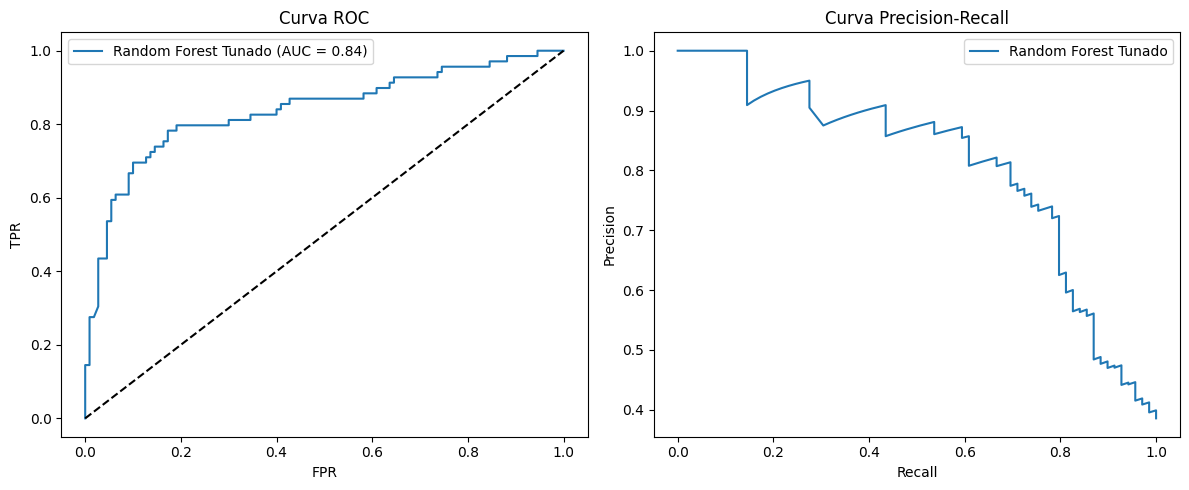

In [6]:
# IMPORTAÇÃO DAS BIBLIOTECAS
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, roc_curve, precision_recall_curve

# CARREGAMENTO E EXPLORAÇÃO DOS DATASETS
df = sns.load_dataset("titanic")
df = df[['survived', 'pclass', 'sex', 'age', 'fare', 'sibsp', 'parch', 'embarked']]

# TRATAMENTO DOS VALORES AUSENTES E TRANSFORMAÇÕES
from sklearn.impute import SimpleImputer

numeric_features = ['age', 'fare']
categorical_features = ['sex', 'embarked', 'pclass']

preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numeric_features),

    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(drop='first'))
    ]), categorical_features)
])

# MODELAGEM E VALIDAÇÃO CRUZADA
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# AVALIAÇÃO DOS MODELOS COM MÉTRICAS
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix

def avaliar_modelo(modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else modelo.decision_function(X_test)

    print("Acurácia:", accuracy_score(y_test, y_pred))
    print("F1-score:", f1_score(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))
    print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))

# CURVAS ROC E PRECISION-RECALL
from sklearn.metrics import roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

def plotar_curvas(modelo, X_test, y_test, nome_modelo):
    y_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else modelo.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)

    plt.figure(figsize=(12, 5))

    # ROC
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'{nome_modelo} (AUC = {roc_auc_score(y_test, y_proba):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('Curva ROC')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()

    # Precision-Recall
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=nome_modelo)
    plt.title('Curva Precision-Recall')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

    plt.tight_layout()
    plt.show()

# SEPARAÇÃO DE DADOS
X = df.drop("survived", axis=1)
y = df["survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# CRIAÇÃO DE PIPELINES E TREINAMENTO DE MODELOS
  # random forest
rf_pipeline = Pipeline(steps=[
    ('preprocessamento', preprocessor),
    ('modelo', RandomForestClassifier(random_state=42))
])

rf_pipeline.fit(X_train, y_train)

  # svm
svm_pipeline = Pipeline(steps=[
    ('preprocessamento', preprocessor),
    ('modelo', SVC(kernel='rbf', probability=True, random_state=42))
])

svm_pipeline.fit(X_train, y_train)

  # xgBoost
xgb_pipeline = Pipeline(steps=[
    ('preprocessamento', preprocessor),
    ('modelo', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

xgb_pipeline.fit(X_train, y_train)

# AVALIAÇÃO DE MODELOS
avaliar_modelo(rf_pipeline, X_test, y_test)
plotar_curvas(rf_pipeline, X_test, y_test, "Random Forest")

avaliar_modelo(svm_pipeline, X_test, y_test)
plotar_curvas(svm_pipeline, X_test, y_test, "SVM")

avaliar_modelo(xgb_pipeline, X_test, y_test)
plotar_curvas(xgb_pipeline, X_test, y_test, "XGBoost")

# HIPERPARÂMETROS
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Random Forest
param_rf = {
    'modelo__n_estimators': [100, 200, 300],
    'modelo__max_depth': [None, 5, 10],
    'modelo__min_samples_split': [2, 5, 10]
}

# SVM
param_svm = {
    'modelo__C': [0.1, 1, 10],
    'modelo__gamma': ['scale', 0.1, 1]
}

# XGBoost
param_xgb = {
    'modelo__n_estimators': [100, 200],
    'modelo__max_depth': [3, 6, 10],
    'modelo__learning_rate': [0.01, 0.1, 0.2]
}

search_rf = RandomizedSearchCV(rf_pipeline, param_rf, cv=cv, scoring='roc_auc', n_iter=5, random_state=42)
search_rf.fit(X_train, y_train)

print("Melhores hiperparâmetros RF:", search_rf.best_params_)
avaliar_modelo(search_rf.best_estimator_, X_test, y_test)
plotar_curvas(search_rf.best_estimator_, X_test, y_test, "Random Forest Tunado")